# T7 RNAP Data Analysis for AIPD TEVV (Ikonomova et al.)

## Load hierarchical model calculations and merge with *in silico* metrics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import time
import seaborn as sns

In [6]:

paraphrase = pd.read_csv("../data/selected_sequences.csv")
ppT7 = paraphrase[paraphrase['protein'] == "t7rnapol"]

exp_data_relevant = pd.read_csv("../data/assay/t7_cfe_hierarchical_model.csv")

# Replace 'Variant' nomenclature with t7rnapol, post_score with score
exp_data_relevant['variant'] = exp_data_relevant['variant'].str.replace('Variant ', 't7rnapol_')
exp_data_relevant.rename(columns={"post_score": "score"}, inplace=True)

# Rename variant identity column to match paraphrase
exp_data_relevant.rename(columns={'variant': 'selected_name'}, inplace=True)

## Export data

In [7]:
# Merge on variant names
merged = pd.merge(exp_data_relevant, paraphrase, on='selected_name')
merged.to_csv("../data/output/t7_insilico_merged.csv", index=False)

## Labeling/Filtering
Homologs with a posterior probability score >= 0.05 / num_homologs are considered active.

In [10]:
df_plot = merged.groupby('selected_name')[['dplddt_mean', 'tm_mean', 'seqid', 'log_gfp', 'prob_inactive', 'score']].mean()

# Calc avg percent activity for actives vs inactives:
stat_df = df_plot[['score', 'prob_inactive']]
#stat_df = stat_df[stat_df.index != 'WT']

threshold = exp_data_relevant[exp_data_relevant['selected_name'] == 'No T7']

# Stats threshold = pval / num_samples
num_samples = len(df_plot.index)
threshold_mean = 0.05 / num_samples

# Actives
print("Actives:\n", stat_df[stat_df['prob_inactive'] <= threshold_mean].describe())
# Inactives
print("Inactives:\n", stat_df[stat_df['prob_inactive'] > threshold_mean].describe())

Actives:
        score  prob_inactive
count    0.0            0.0
mean     NaN            NaN
std      NaN            NaN
min      NaN            NaN
25%      NaN            NaN
50%      NaN            NaN
75%      NaN            NaN
max      NaN            NaN
Inactives:
            score  prob_inactive
count  93.000000      93.000000
mean   -0.065354       0.720019
std     0.056902       0.163827
min    -0.207791       0.030667
25%    -0.096312       0.647167
50%    -0.072691       0.751583
75%    -0.039606       0.817167
max     0.159542       0.977833


In [11]:
# Apply activity labels to merged df
merged['active'] = merged['prob_inactive'].apply(lambda x: True if x <= threshold_mean else False)

## Plotting assay results

In [ ]:
# Collect hits/plot
shape_mapping = df_plot['prob_inactive'].apply(lambda x: 'o' if x <= threshold_mean else 'x')
#edge_mapping = df_plot['prob_inactive'].apply(lambda x: 'black' if x <= threshold_mean else [0, 0, 0, 0])

x, y, z = df_plot['dplddt_mean'], df_plot['tm_mean'], df_plot['seqid']

/var/folders/kv/drkyrlls1gjbt2hggx0nyrb40023dp/T/ipykernel_8563/574835135.py:39: UserWarning: You passed a edgecolor/edgecolors (selected_name
t7rnapol_0     [0, 0, 0, 0]
t7rnapol_1     [0, 0, 0, 0]
t7rnapol_10    [0, 0, 0, 0]
t7rnapol_11    [0, 0, 0, 0]
t7rnapol_12    [0, 0, 0, 0]
                   ...     
t7rnapol_94    [0, 0, 0, 0]
t7rnapol_95    [0, 0, 0, 0]
t7rnapol_96    [0, 0, 0, 0]
t7rnapol_97    [0, 0, 0, 0]
t7rnapol_98    [0, 0, 0, 0]
Name: prob_inactive, Length: 93, dtype: object) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  surf = ax.scatter(x[mask], y[mask], z[mask],


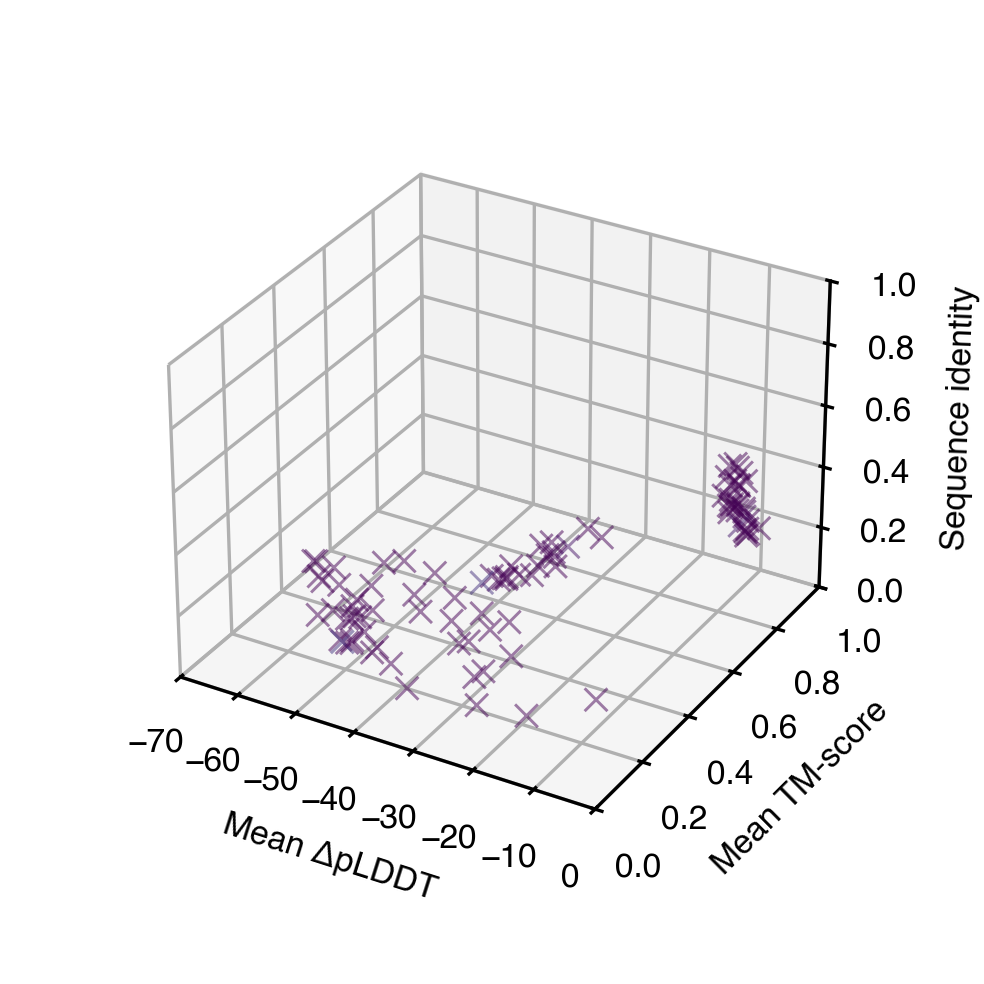

In [ ]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 8})
font = {'fontname':'Helvetica'}
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect(None, zoom=0.80)
ax.set_xlabel('Mean ΔpLDDT')
ax.set_xlim(-70, 0)
ax.set_ylabel('Mean TM-score')
ax.set_ylim(0, 1)
ax.set_zlabel('Sequence identity')
ax.set_zlim(0, 1)

# plot a 3D surface like in the example mplot3d/surface3d_demo
cmap = sns.color_palette("viridis", as_cmap=True)
# Clip color mapping to [0,1]
vmin = 0
vmax = 1
for shape in np.unique(shape_mapping):
    mask = shape_mapping == shape
    surf = ax.scatter(x[mask], y[mask], z[mask],
                    s=30,
                    alpha=0.5,
                    c=df_plot.loc[mask, 'post_score'],
                    marker=shape,
                    #edgecolors=edge_mapping[mask],
                    linewidths=0.7,
                    cmap=cmap,
                    vmin=vmin,
                    vmax=vmax,
                    )

ax.set_zlim(0, 1.0)
#fig.colorbar(surf, shrink=0.3, aspect=10)

# Create a vertical plane at x=2
# Get the current y and z limits
y_min, y_max = ax.get_ylim()
z_min, z_max = ax.get_zlim()

plt.show()

## BLAST Flagging

In [18]:
activity_variants = merged[['selected_name', 'active']]
activity_variants = activity_variants.groupby('selected_name').agg({
    'active': 'max'
})

blast = pd.read_csv("../data/blast/t7rnapol_blast_results.csv")
blast['query_sequence'] = blast['query_sequence'].str.replace('_M1', '')
blast = pd.merge(blast, activity_variants, left_on='query_sequence', right_on='selected_name')

In [17]:
### Flagger function

from Bio import Entrez

import requests
from bs4 import BeautifulSoup

# Function to fetch the metadata from the PDB landing page
def fetch_pdb_metadata_from_web(pdb_id):
    url = f"https://www.rcsb.org/structure/{pdb_id}"
    response = requests.get(url)
    
    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract the title of the structure
        title = soup.find('span', id='structureTitle').get_text(strip=True)
        
        # Extract the description/annotations (generally in the first paragraph or under a specific div)
        description_div = soup.find('div', class_='abstract')
        if description_div:
            description = description_div.get_text(strip=True)
        else:
            description = "No description available."
        
        return title, description
    else:
        print(f"Failed to fetch PDB {pdb_id}. HTTP Status: {response.status_code}")
        return None, None

def fetch_ncbi_record(query,
                      keyword_phrase="rna polymerase",
                      email="geoffrey.taghon@nist.gov"):
    """
    Fetch an NCBI record using an accession number, regardless of database source.
    
    Parameters:
    query (str): The database and accession number (e.g., 'nucleotide|NM_123456')
    keyword_phrase (str): The phrase to search for (e.g., 'rna polymerase')
    email (str): Your email address for NCBI API access
    
    Returns:
    Boolean: True if all keywords in the phrase are found in the record, False otherwise
    """
    Entrez.email = email
    time.sleep(1)

    # If no top match, no flag
    if pd.isna(query):
        return False
    else:
        database, accession = str(query).split("|")[0], str(query).split("|")[1]
    
    # Convert keyword phrase to lowercase and split into individual keywords
    keywords = keyword_phrase.lower().split()
    
    # If PDB hit, handle differently
    if database == "pdb":
        title, description = fetch_pdb_metadata_from_web(accession)
        # Convert title to lowercase for case-insensitive search
        agg_info = title + description
        agg_info = agg_info.lower()
        # Check if all keywords are in the title
        if all(keyword in agg_info for keyword in keywords):
            return True
    
    # First, try to get the record from nucleotide database (covers most types)
    try:
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="xml", retmode="xml")
        record = handle.read()  # This returns bytes
        handle.close()
        # Convert bytes to string and make lowercase
        record_str = str(record).lower()
        if all(keyword in record_str for keyword in keywords):
            return True
    except Exception as e:
        print(f"Couldn't fetch from nucleotide database: {e}")
    
    # If that fails, try the protein database
    try:
        handle = Entrez.efetch(db="protein", id=accession, rettype="xml", retmode="xml")
        record = handle.read()  # This returns bytes
        handle.close()
        # Convert bytes to string and make lowercase
        record_str = str(record).lower()
        if all(keyword in record_str for keyword in keywords):
            return True
    except Exception as e:
        print(f"Couldn't fetch from protein database: {e}")
    
    # If both fail, try to search for the accession across databases
    try:
        # Use esearch to find which database the accession belongs to
        search_handle = Entrez.esearch(term=accession, retmax=1)
        search_results = Entrez.read(search_handle)
        search_handle.close()
        
        if search_results["Count"] != "0":
            record_id = search_results["IdList"][0]
            # Try to fetch using the found ID
            handle = Entrez.efetch(id=record_id, rettype="xml", retmode="xml")
            record = handle.read()  # This returns bytes
            handle.close()
            # Convert bytes to string and make lowercase
            record_str = str(record).lower()
            if all(keyword in record_str for keyword in keywords):
                return True
    except Exception as e:
        print(f"Couldn't find the accession in any database: {e}")
    
    return False

if not os.path.exists('../data/output/t7rnapol_blast_flags.csv'):
    blast['flagged'] = blast['top_match'].apply(fetch_ncbi_record)
    blast.to_csv("../data/output/t7rnapol_blast_flags.csv")

## Plotting BLAST confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def plot_confusion_matrix(y_true, y_pred, figsize=(4, 5), cmap='Blues', title='T7 RNAP'):
    """
    Create a visually appealing confusion matrix plot from two boolean series.
    
    Parameters:
    y_true (pd.Series or array-like): Series of actual values (TRUE/FALSE)
    y_pred (pd.Series or array-like): Series of predicted values (TRUE/FALSE)
    figsize (tuple): Figure size as (width, height)
    cmap (str): Colormap for the heatmap
    title (str): Title for the plot
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    # Ensure inputs are boolean
    y_true = pd.Series(y_true).astype(bool)
    y_pred = pd.Series(y_pred).astype(bool)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot heatmap
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap=cmap,
        vmin=0,
        vmax=len(blast),
        linewidths=.5,
        square=True,
        cbar=False,
        annot_kws={"size": 32},
        ax=ax
    )
    
    # Labels, title and ticks
    ax.set_xlabel('Flagged by BLAST', fontsize=14, labelpad=10)
    ax.set_ylabel('Above threshold', fontsize=14, labelpad=10)
    ax.set_title(title, fontsize=16, pad=20)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
    # Set custom x and y tick labels
    ax.set_xticklabels(['–', '+'], fontsize=22)
    ax.set_yticklabels(['–', '+'], fontsize=22, rotation=0)
    
    # Add text annotations for the cells with descriptive labels
    categories = ['True negative', 'False positive', 'False negative', 'True positive']
    positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
    
    for i, (pos_y, pos_x) in enumerate(positions):
        ax.text(
            pos_x + 0.5, 
            pos_y + 0.85, 
            categories[i],
            horizontalalignment='center',
            size=14,
            color='black' if cm[pos_y, pos_x] < (len(blast) / 2) else 'white'
        )
    
    # Add metrics as text below the matrix
    """
    plt.figtext(0.5, 0.01, 
                f'Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1 Score: {f1:.3f}',
                ha="center", 
                fontsize=12, 
                bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    """
    
    plt.tight_layout()

/usr/local/Caskroom/miniconda/base/envs/clip-search/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


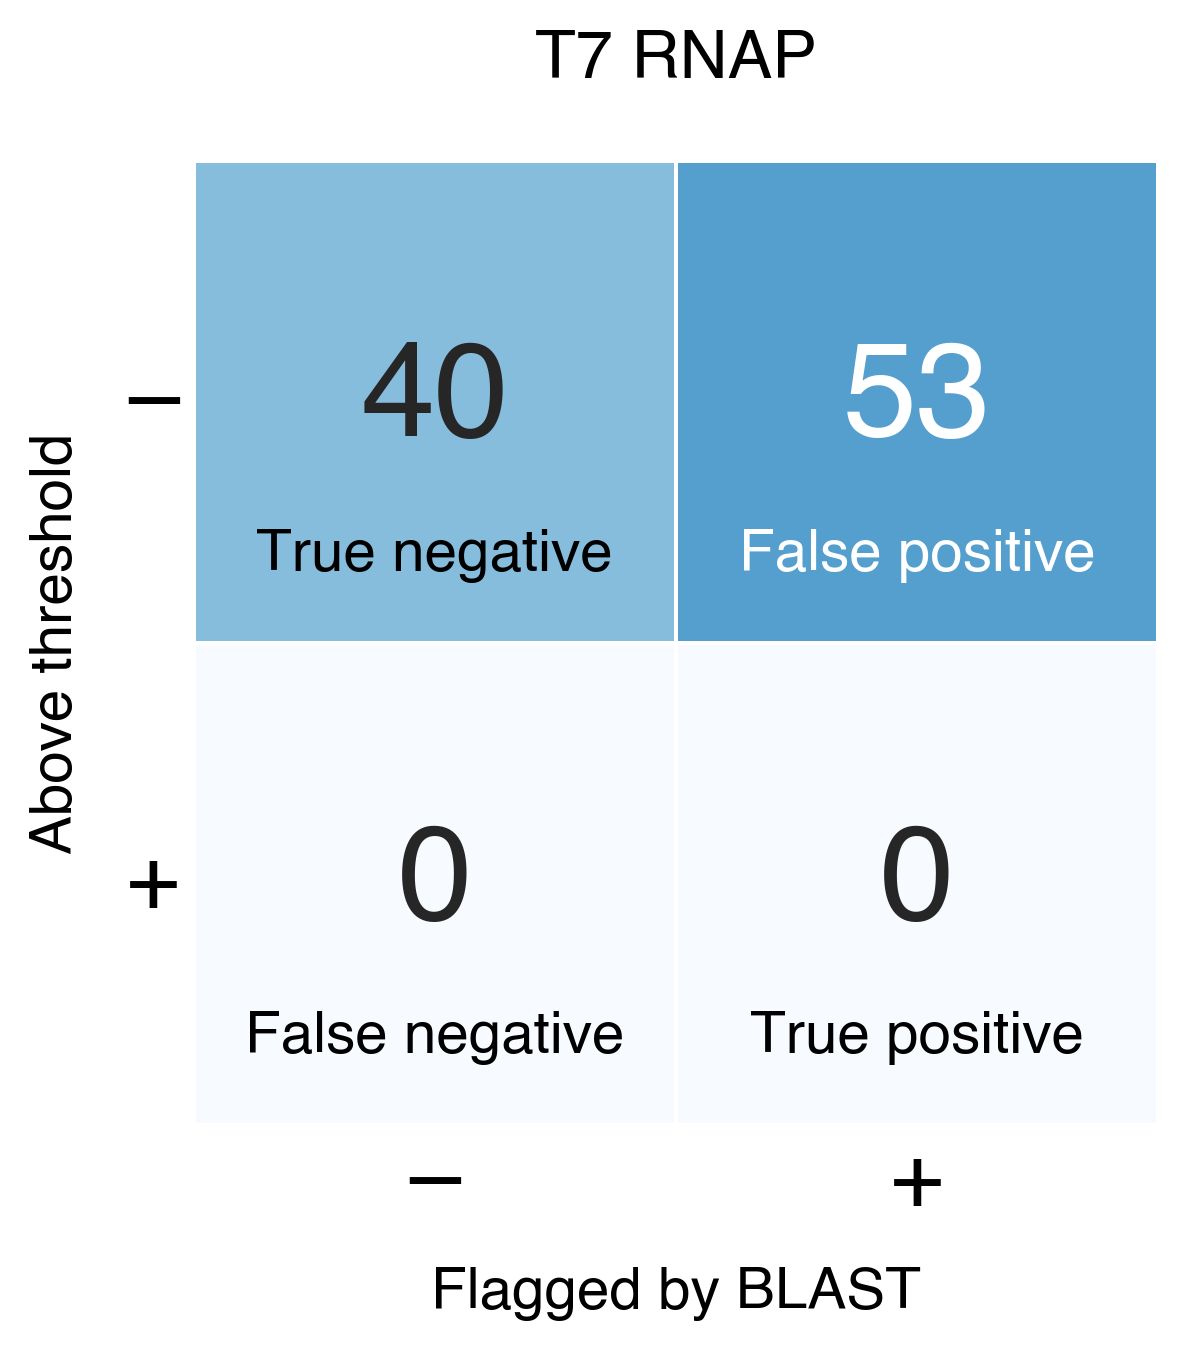

In [ ]:
blast = pd.read_csv('t7rnapol_blast_flags.csv')

plot_confusion_matrix(blast['active'], blast['flagged'])